In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_ensemble

%load_ext autoreload
%autoreload 1

2022-07-28 14:29:21.034320: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-28 14:29:21.039045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-28 14:29:21.039068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 185929.70it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

### Training loop

In [6]:
loss = nn.CosineEmbeddingLoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512
    
models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_no_regularization/')
models_path.mkdir(parents=True, exist_ok=True)

In [7]:
# N_EPOCHS = 10
# N_MODELS = 5
# proj_hidden_size = 512

# train_ensemble(N_MODELS, N_EPOCHS, proj_hidden_size, train_dataset, val_dataloader, models_path, device):

### Load pretrained model

In [8]:
%autoreload

N_MODELS = 5
proj_hidden_size = 512

encoder = EncoderBERT(device)
projection_E = get_projection_module_simple(device, proj_hidden_size)
projection_Q = get_projection_module_simple(device, proj_hidden_size)
projection_P = get_projection_module_simple(device, proj_hidden_size)

encoder.load_state_dict(torch.load(models_path / f'encoder_0.pt'))
projection_E.load_state_dict(torch.load(models_path / f'projection_E_0.pt'))
projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_0.pt'))
projection_P.load_state_dict(torch.load(models_path / f'projection_P_0.pt'))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

## Eval

### RuBQ

In [9]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

In [10]:
candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Eval ensemble

### Select optimal number of models

In [11]:
# ensemble_sizes = range(2, 20)

# accs = []

# for N_MODELS in ensemble_sizes:
#     models = []

#     for _ in range(N_MODELS):
#         models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E, 'dropout_mask': True})
        
#     q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, models, device)
    
#     accs.append(acc)

# plt.plot(ensemble_sizes, accs)

# optimal_N_MODELS = ensemble_sizes[np.argsort(accs)[-1]]

In [12]:
models = []

N_MODELS = 10

for _ in range(N_MODELS):
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E, 'dropout_mask': True})

In [13]:
%autoreload

from eval_models import eval_ensemble

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.4873524451939292


In [14]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [15]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### Now with delta-based rejection

In [16]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(delta)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### StD of embeddings

In [17]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

total_stds = np.array([e_stds, p_stds, q_stds]).mean(axis=0)

rubq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(e_stds)[mask], recalls)
rubq_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(p_stds)[mask], recalls)
rubq_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(q_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

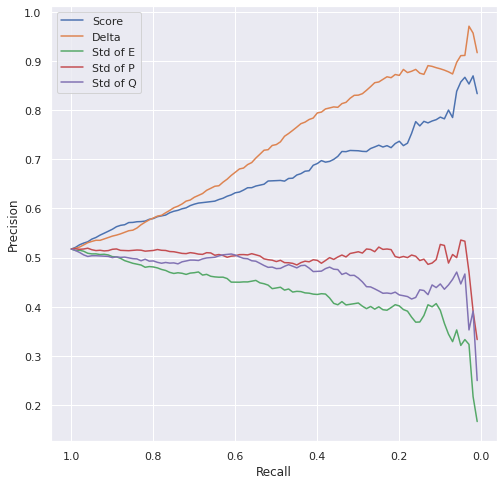

In [18]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs, label='Std of E')
ax.plot(recalls, rubq_p_accs, label='Std of P')
ax.plot(recalls, rubq_q_accs, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of Normalized embeddings

In [19]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(e_stds_norm)[mask], recalls)
rubq_p_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(p_stds_norm)[mask], recalls)
rubq_q_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(q_stds_norm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

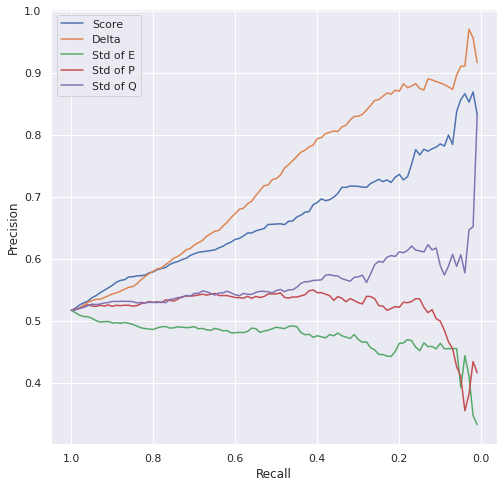

In [20]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_norm, label='Std of E')
ax.plot(recalls, rubq_p_accs_norm, label='Std of P')
ax.plot(recalls, rubq_q_accs_norm, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of scores

In [21]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_cosine_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)
rubq_cosine_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_P_stds)[mask], recalls)
rubq_cosine_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_Q_stds)[mask], recalls)
rubq_cosine_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

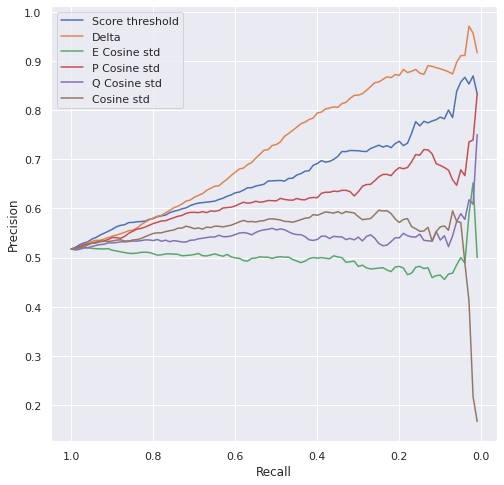

In [22]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_cosine_e_accs, label='E Cosine std')
ax.plot(recalls, rubq_cosine_p_accs, label='P Cosine std')
ax.plot(recalls, rubq_cosine_q_accs, label='Q Cosine std')
ax.plot(recalls, rubq_cosine_accs, label='Cosine std')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Entropy and MI

In [23]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

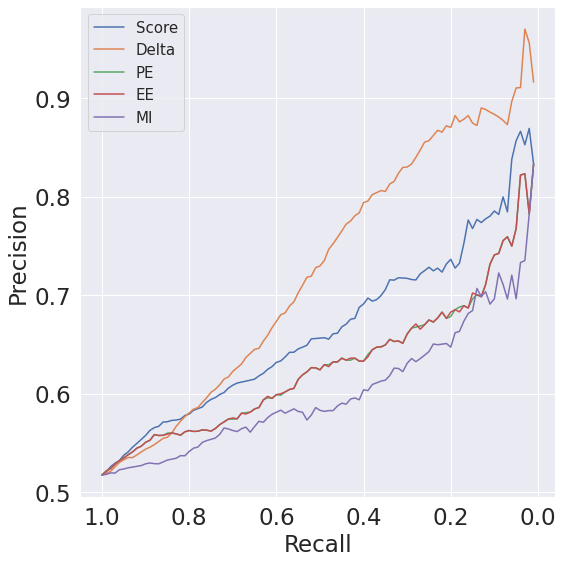

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs, label='PE')
ax.plot(recalls, rubq_ee_accs, label='EE')
ax.plot(recalls, rubq_mi_accs, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [25]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=10)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.48650927487352447


In [26]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

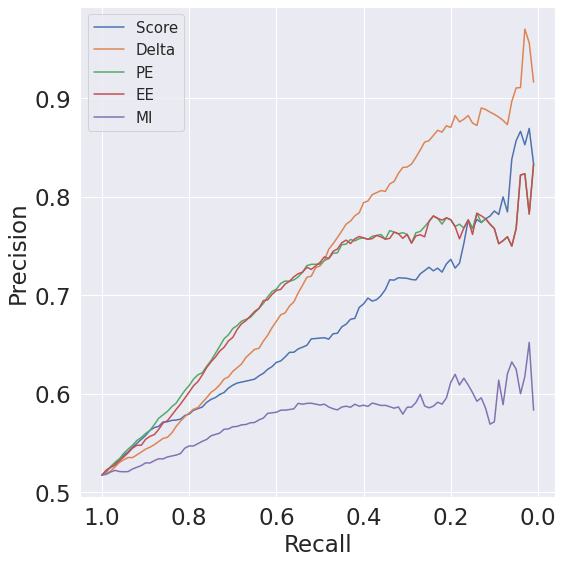

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_10, label='PE')
ax.plot(recalls, rubq_ee_accs_10, label='EE')
ax.plot(recalls, rubq_mi_accs_10, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [28]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=8)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [02:04,  9.53it/s]

Accuracy:  0.48650927487352447


In [29]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

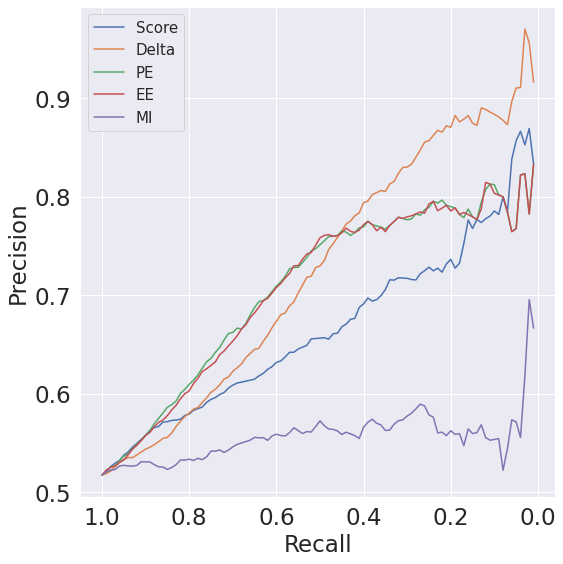

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_8, label='PE')
ax.plot(recalls, rubq_ee_accs_8, label='EE')
ax.plot(recalls, rubq_mi_accs_8, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [31]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=5)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [02:03,  9.64it/s]

Accuracy:  0.4856661045531197


In [32]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

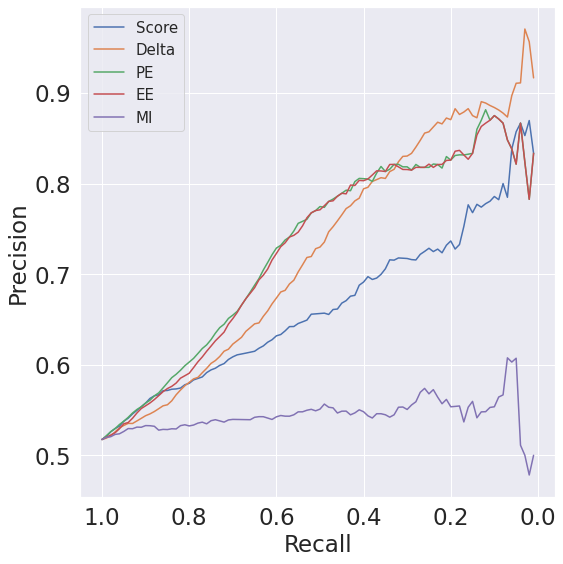

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_5, label='PE')
ax.plot(recalls, rubq_ee_accs_5, label='EE')
ax.plot(recalls, rubq_mi_accs_5, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [34]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=3)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [02:01,  9.79it/s]

Accuracy:  0.49156829679595276


In [35]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

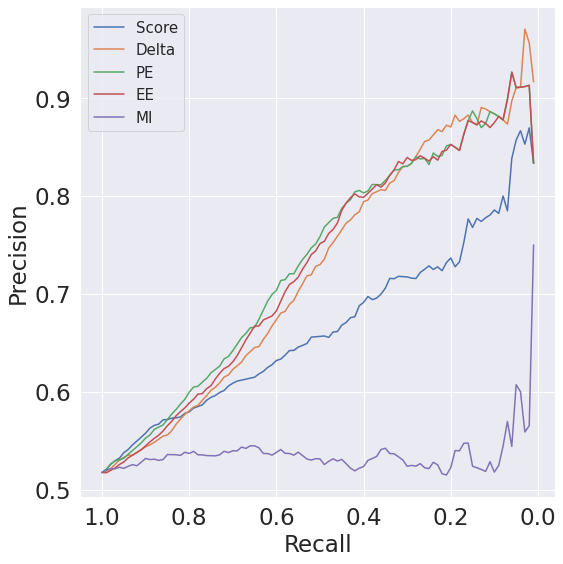

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_3, label='PE')
ax.plot(recalls, rubq_ee_accs_3, label='EE')
ax.plot(recalls, rubq_mi_accs_3, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Delta as stat hypothesis

In [37]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, all_cosines = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=3)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [02:02,  9.66it/s]

Accuracy:  0.4856661045531197


In [38]:
from scipy.stats import ttest_ind

pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


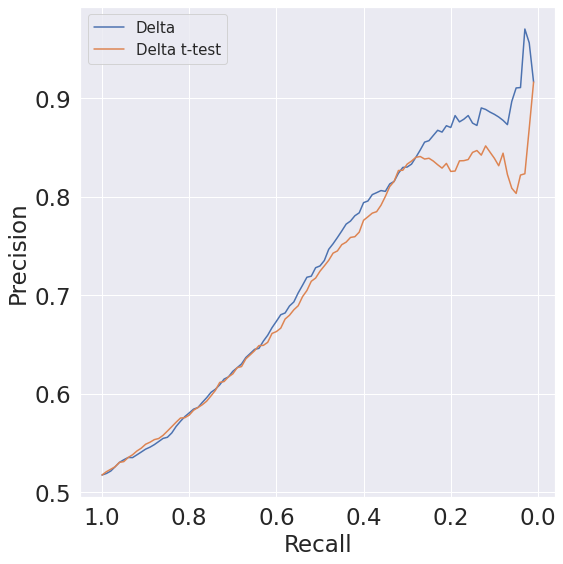

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_pvalues_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [40]:
pvalues_perm = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues_perm.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues_perm.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater', permutations=252).pvalue)
        except:
            set_trace()
    else:
        pvalues_perm.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_pvalues_perm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(pvalues_perm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


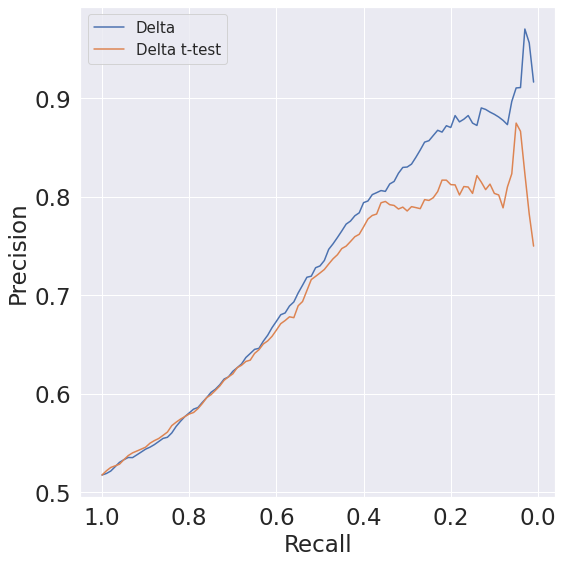

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_pvalues_perm_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [42]:
from scipy.stats import wilcoxon

wilc_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        wilc_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            wilc_pvalues.append(wilcoxon(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        wilc_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_wilc_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(wilc_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


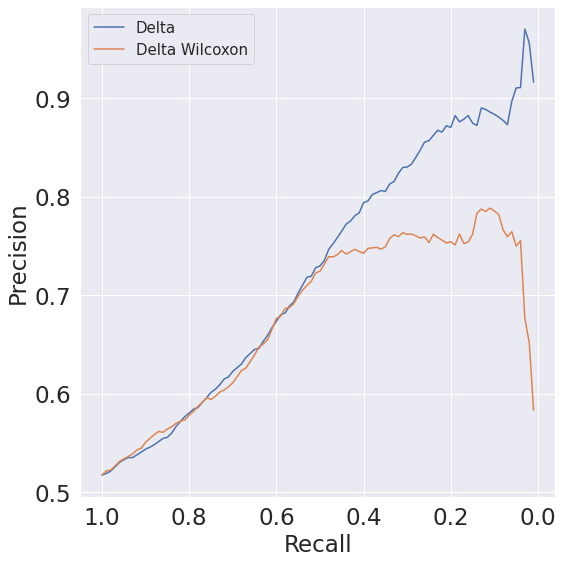

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_wilc_pvalues_accs, label='Delta Wilcoxon')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [44]:
from scipy.stats import ranksums

ranksum_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        ranksum_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            ranksum_pvalues.append(ranksums(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        ranksum_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_ranksum_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(ranksum_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


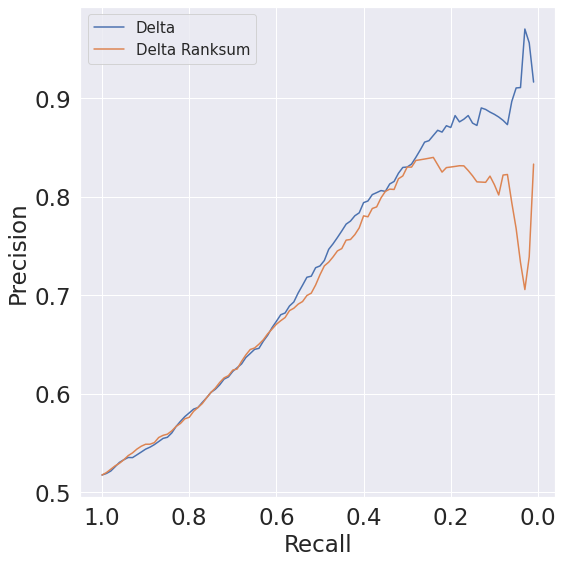

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_ranksum_pvalues_accs, label='Delta Ranksum')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Simple Questions

In [46]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [47]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [48]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 162007.94it/s]


In [49]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:35,  8.85it/s]

Accuracy:  0.5229696472518458


In [50]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [51]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### Now with delta-based rejection

In [52]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(delta)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### StD of embeddings

In [53]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

total_stds = np.array([e_stds, p_stds, q_stds]).mean(axis=0)

sq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(e_stds)[mask], recalls)
sq_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(p_stds)[mask], recalls)
sq_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(q_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

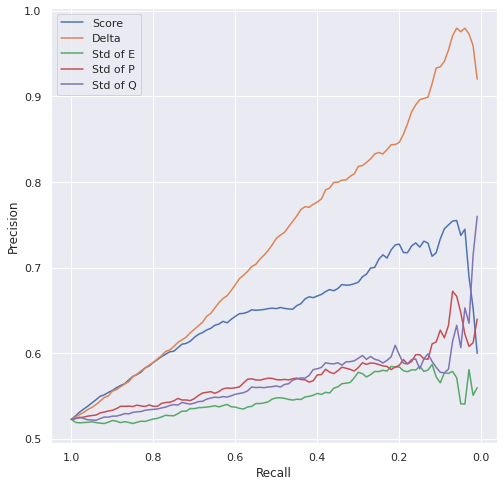

In [54]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs, label='Std of E')
ax.plot(recalls, sq_p_accs, label='Std of P')
ax.plot(recalls, sq_q_accs, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of Normalized embeddings

In [55]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(e_stds_norm)[mask], recalls)
sq_p_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(p_stds_norm)[mask], recalls)
sq_q_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(q_stds_norm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

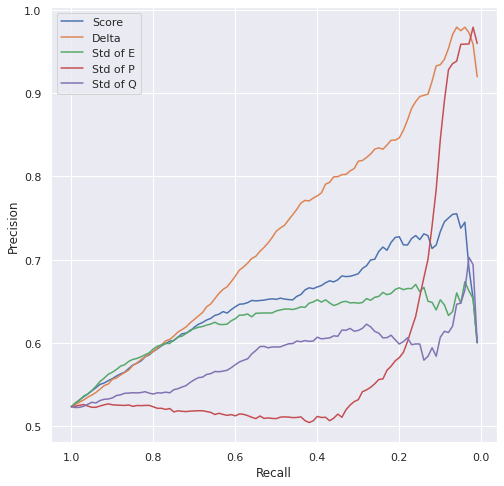

In [56]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_norm, label='Std of E')
ax.plot(recalls, sq_p_accs_norm, label='Std of P')
ax.plot(recalls, sq_q_accs_norm, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of scores

In [57]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_cosine_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)
sq_cosine_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_P_stds)[mask], recalls)
sq_cosine_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_Q_stds)[mask], recalls)
sq_cosine_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

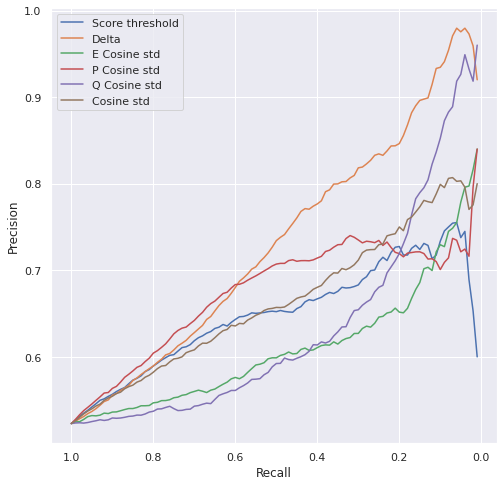

In [58]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_cosine_e_accs, label='E Cosine std')
ax.plot(recalls, sq_cosine_p_accs, label='P Cosine std')
ax.plot(recalls, sq_cosine_q_accs, label='Q Cosine std')
ax.plot(recalls, sq_cosine_accs, label='Cosine std')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Entropy and MI

In [59]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_ee_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

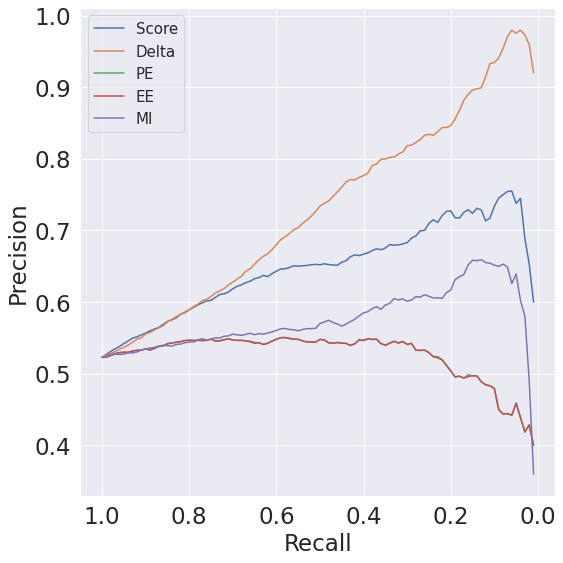

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs, label='PE')
ax.plot(recalls, sq_ee_accs, label='EE')
ax.plot(recalls, sq_mi_accs, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [61]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=10)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:39,  8.73it/s]

Accuracy:  0.5278917145200984


In [62]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

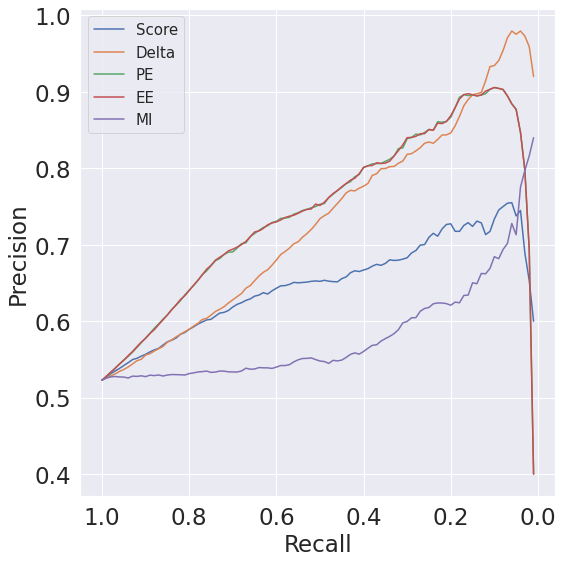

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_10, label='PE')
ax.plot(recalls, sq_ee_accs_10, label='EE')
ax.plot(recalls, sq_mi_accs_10, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [64]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=8)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:40,  8.70it/s]

Accuracy:  0.5217391304347826


In [65]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

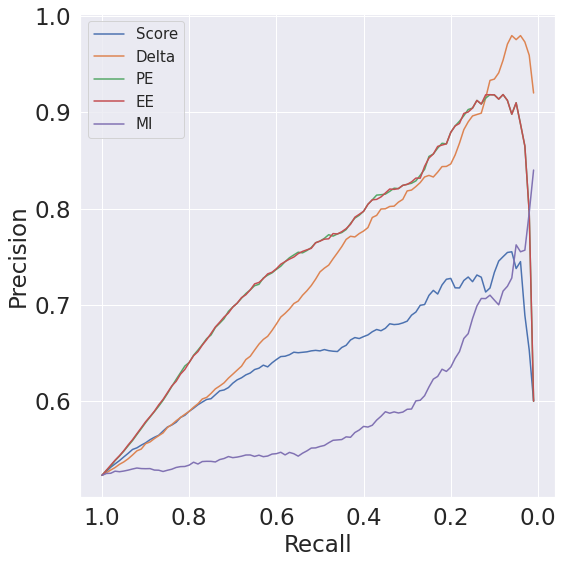

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_8, label='PE')
ax.plot(recalls, sq_ee_accs_8, label='EE')
ax.plot(recalls, sq_mi_accs_8, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [67]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=5)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:40,  8.69it/s]

Accuracy:  0.5237899917965545


In [68]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

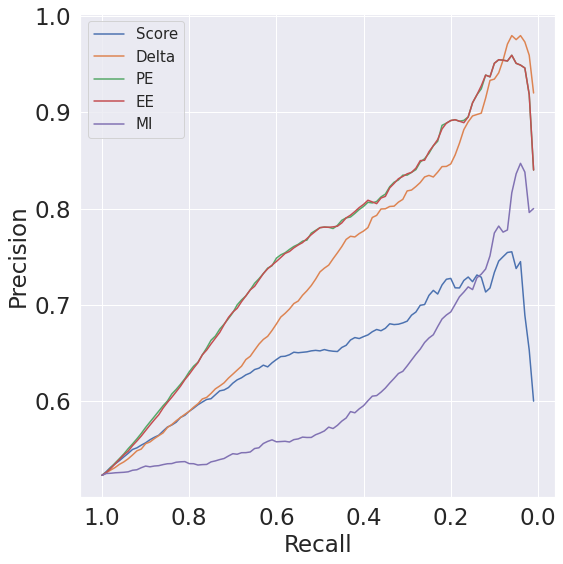

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_5, label='PE')
ax.plot(recalls, sq_ee_accs_5, label='EE')
ax.plot(recalls, sq_mi_accs_5, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [70]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=3)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:38,  8.74it/s]

Accuracy:  0.522149302707137


In [71]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

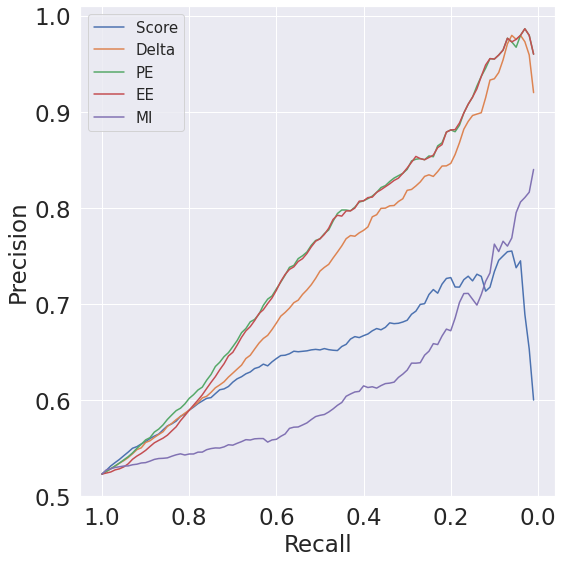

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_3, label='PE')
ax.plot(recalls, sq_ee_accs_3, label='EE')
ax.plot(recalls, sq_mi_accs_3, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [73]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, all_cosines = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [04:40,  8.70it/s]

Accuracy:  0.5250205086136177


In [74]:
from scipy.stats import ttest_ind

pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


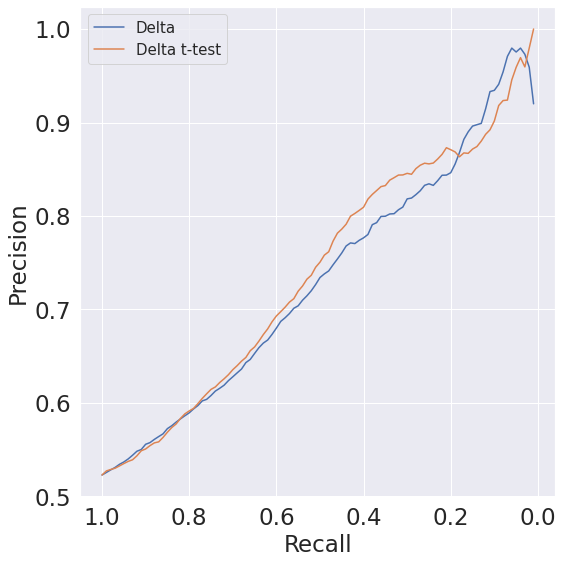

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_pvalues_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [76]:
pvalues_perm = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues_perm.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues_perm.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater', permutations=252).pvalue)
        except:
            set_trace()
    else:
        pvalues_perm.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_pvalues_perm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(pvalues_perm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


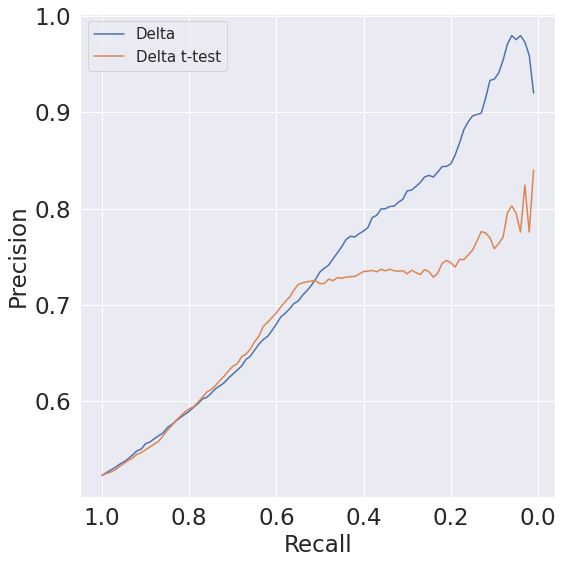

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_pvalues_perm_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [78]:
from scipy.stats import wilcoxon

wilc_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        wilc_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            wilc_pvalues.append(wilcoxon(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        wilc_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_wilc_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(wilc_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


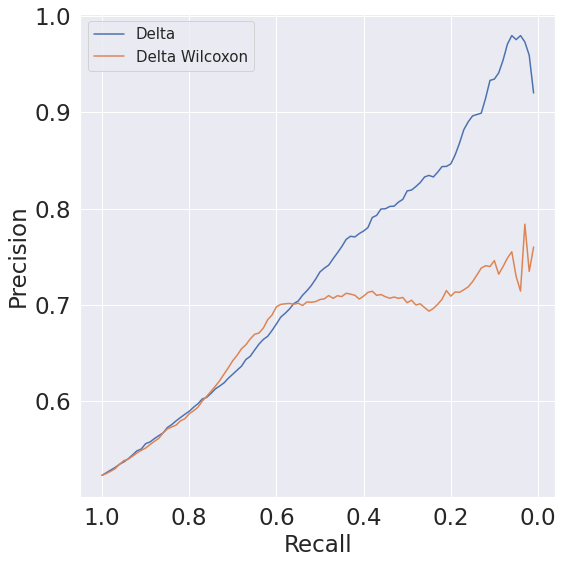

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_wilc_pvalues_accs, label='Delta Wilcoxon')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [80]:
from scipy.stats import ranksums

ranksum_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        ranksum_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            ranksum_pvalues.append(ranksums(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        ranksum_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_ranksum_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(ranksum_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


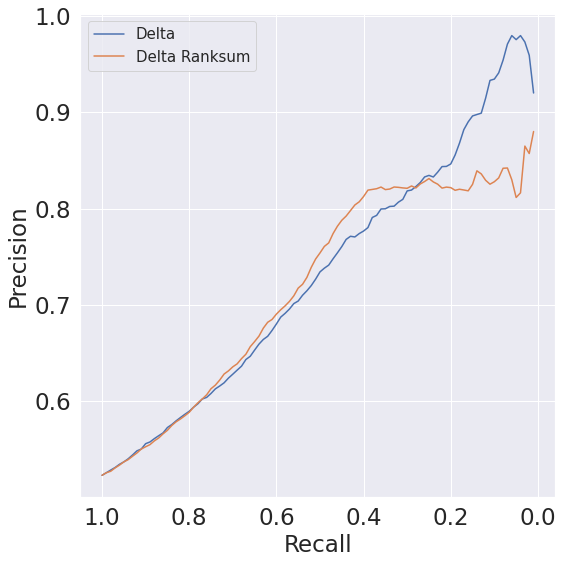

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_ranksum_pvalues_accs, label='Delta Ranksum')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [82]:
from sklearn.metrics import auc

rubq_rejected_accs = [
    rubq_score_accs,
    rubq_delta_accs,
    rubq_e_accs,
    rubq_p_accs,
    rubq_q_accs,
    rubq_e_accs_norm,
    rubq_p_accs_norm,
    rubq_q_accs_norm,
    rubq_cosine_e_accs,
    rubq_cosine_p_accs,
    rubq_cosine_q_accs,
    rubq_cosine_accs,
    rubq_ee_accs,
    rubq_pe_accs,
    rubq_mi_accs,
    rubq_ee_accs_10,
    rubq_pe_accs_10,
    rubq_mi_accs_10,
    rubq_ee_accs_8,
    rubq_pe_accs_8,
    rubq_mi_accs_8,
    rubq_ee_accs_5,
    rubq_pe_accs_5,
    rubq_mi_accs_5,
    rubq_ee_accs_3,
    rubq_pe_accs_3,
    rubq_mi_accs_3,
    rubq_delta_pvalues_accs,
    rubq_delta_pvalues_perm_accs,
    rubq_delta_wilc_pvalues_accs,
    rubq_delta_ranksum_pvalues_accs
]

rubq_rejected_acc_names = [
    'rubq_score_accs',
    'rubq_delta_accs',
    'rubq_e_accs',
    'rubq_p_accs',
    'rubq_q_accs',
    'rubq_e_accs_norm',
    'rubq_p_accs_norm',
    'rubq_q_accs_norm',
    'rubq_cosine_e_accs',
    'rubq_cosine_p_accs',
    'rubq_cosine_q_accs',
    'rubq_cosine_accs',
    'rubq_ee_accs',
    'rubq_pe_accs',
    'rubq_mi_accs',
    'rubq_ee_accs_10',
    'rubq_pe_accs_10',
    'rubq_mi_accs_10',
    'rubq_ee_accs_8',
    'rubq_pe_accs_8',
    'rubq_mi_accs_8',
    'rubq_ee_accs_5',
    'rubq_pe_accs_5',
    'rubq_mi_accs_5',
    'rubq_ee_accs_3',
    'rubq_pe_accs_3',
    'rubq_mi_accs_3',
    'rubq_delta_pvalues_accs',
    'rubq_delta_pvalues_perm_accs',
    'rubq_delta_wilc_pvalues_accs',
    'rubq_delta_ranksum_pvalues_accs'
]

rubq_aucs = []
for acc_ary in rubq_rejected_accs:
    rubq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(rubq_aucs))

sorted_aucs = np.array(rubq_aucs)[sorting]
sorted_names = np.array(rubq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

rubq_pe_accs_3 0.7251634533415854
rubq_pe_accs_5 0.7217789777311364
rubq_ee_accs_3 0.7197933805144215
rubq_ee_accs_5 0.7189750852601345
rubq_delta_accs 0.716740250333447
rubq_delta_pvalues_accs 0.70081766636258
rubq_pe_accs_8 0.7004804280130703
rubq_ee_accs_8 0.6988640815078331
rubq_delta_ranksum_pvalues_accs 0.6942614320840984
rubq_pe_accs_10 0.6917974037944138
rubq_delta_pvalues_perm_accs 0.6905821749235905
rubq_ee_accs_10 0.6896405017563918
rubq_delta_wilc_pvalues_accs 0.6714971185355181
rubq_score_accs 0.6572655940376014
rubq_ee_accs 0.6211512816277613
rubq_pe_accs 0.6211000595428071
rubq_cosine_p_accs 0.6109187780872269
rubq_mi_accs 0.5948572565270672
rubq_mi_accs_10 0.569139365240963
rubq_q_accs_norm 0.5568571742140165
rubq_cosine_accs 0.5507328161433858
rubq_mi_accs_8 0.5496273766245473
rubq_mi_accs_5 0.5386964923984864
rubq_cosine_q_accs 0.5371496974016383
rubq_mi_accs_3 0.529742591921669
rubq_p_accs_norm 0.5186338482713027
rubq_p_accs 0.4992920797760918
rubq_cosine_e_accs 0.49

In [83]:
from sklearn.metrics import auc

sq_rejected_accs = [
    sq_score_accs,
    sq_delta_accs,
    sq_e_accs,
    sq_p_accs,
    sq_q_accs,
    sq_e_accs_norm,
    sq_p_accs_norm,
    sq_q_accs_norm,
    sq_cosine_e_accs,
    sq_cosine_p_accs,
    sq_cosine_q_accs,
    sq_cosine_accs,
    sq_ee_accs,
    sq_pe_accs,
    sq_mi_accs,
    sq_ee_accs_10,
    sq_pe_accs_10,
    sq_mi_accs_10,
    sq_ee_accs_8,
    sq_pe_accs_8,
    sq_mi_accs_8,
    sq_ee_accs_5,
    sq_pe_accs_5,
    sq_mi_accs_5,
    sq_ee_accs_3,
    sq_pe_accs_3,
    sq_mi_accs_3,
    sq_delta_pvalues_accs,
    sq_delta_pvalues_perm_accs,
    sq_delta_wilc_pvalues_accs,
    sq_delta_ranksum_pvalues_accs
]

sq_rejected_acc_names = [
    'sq_score_accs',
    'sq_delta_accs',
    'sq_e_accs',
    'sq_p_accs',
    'sq_q_accs',
    'sq_e_accs_norm',
    'sq_p_accs_norm',
    'sq_q_accs_norm',
    'sq_cosine_e_accs',
    'sq_cosine_p_accs',
    'sq_cosine_q_accs',
    'sq_cosine_accs',
    'sq_ee_accs',
    'sq_pe_accs',
    'sq_mi_accs',
    'sq_ee_accs_10',
    'sq_pe_accs_10',
    'sq_mi_accs_10',
    'sq_ee_accs_8',
    'sq_pe_accs_8',
    'sq_mi_accs_8',
    'sq_ee_accs_5',
    'sq_pe_accs_5',
    'sq_mi_accs_5',
    'sq_ee_accs_3',
    'sq_pe_accs_3',
    'sq_mi_accs_3',
    'sq_delta_pvalues_accs',
    'sq_delta_pvalues_perm_accs',
    'sq_delta_wilc_pvalues_accs',
    'sq_delta_ranksum_pvalues_accs'
]

sq_aucs = []
for acc_ary in sq_rejected_accs:
    sq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(sq_aucs))

sorted_aucs = np.array(sq_aucs)[sorting]
sorted_names = np.array(sq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

sq_pe_accs_5 0.751921363325429
sq_ee_accs_5 0.7511849107020224
sq_pe_accs_3 0.7440949385512625
sq_ee_accs_8 0.7432002211593082
sq_pe_accs_8 0.7431271121144511
sq_ee_accs_3 0.7408255347449029
sq_ee_accs_10 0.7363307695642995
sq_pe_accs_10 0.7362416161294061
sq_delta_pvalues_accs 0.7303949159081693
sq_delta_accs 0.7224545678618267
sq_delta_ranksum_pvalues_accs 0.7111087028082265
sq_delta_pvalues_perm_accs 0.6762842496911802
sq_cosine_p_accs 0.6657986628640797
sq_delta_wilc_pvalues_accs 0.6602364538513817
sq_cosine_accs 0.6554371289555218
sq_score_accs 0.6412623160239111
sq_cosine_q_accs 0.6242988111757392
sq_e_accs_norm 0.6172809217182404
sq_mi_accs_3 0.6036097551991488
sq_cosine_e_accs 0.6024353915682337
sq_mi_accs_5 0.6021693725020087
sq_mi_accs_8 0.5796471195078668
sq_q_accs_norm 0.5757966304385427
sq_mi_accs_10 0.5734630631263683
sq_mi_accs 0.5699630193607813
sq_p_accs_norm 0.5690959484138272
sq_p_accs 0.5637793127436258
sq_q_accs 0.5611253146180466
sq_e_accs 0.5423388225679584
sq_pe